# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.084971,True,5.082602
1,-0.396269,False,-1.438821
2,2.173867,True,11.479422
3,2.916317,True,12.012286
4,-0.235892,False,-1.628292
...,...,...,...
995,0.717345,False,3.224835
996,0.133643,True,6.297357
997,2.422548,True,9.256972
998,2.320712,True,9.223372


<AxesSubplot:xlabel='v0'>

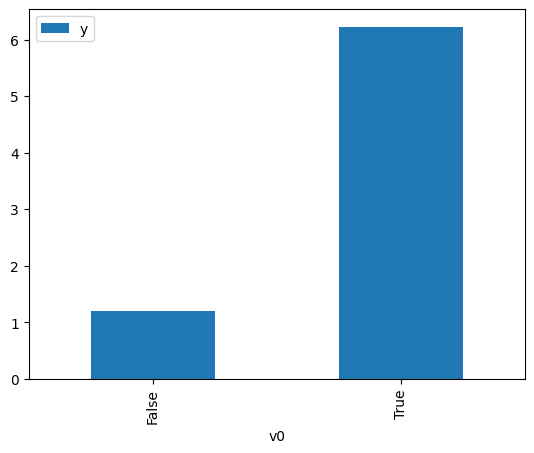

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

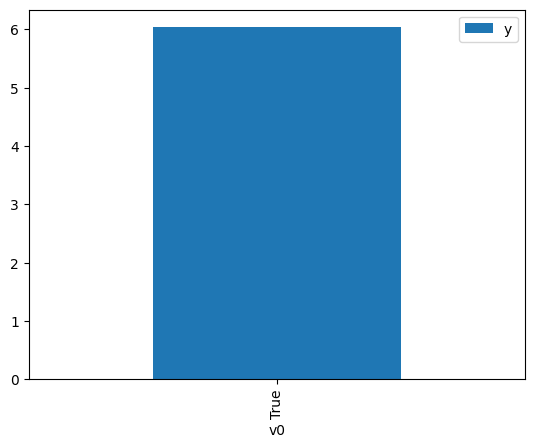

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,2.733335,False,5.068516,0.236241,4.232967
1,0.744809,False,2.943351,0.429863,2.326321
2,-0.004642,False,-0.228659,0.513346,1.948005
3,-0.064713,False,0.487385,0.520067,1.922829
4,-0.247730,False,-1.324791,0.540490,1.850174
...,...,...,...,...,...
995,0.170275,False,1.072593,0.493756,2.025294
996,0.553883,False,-0.995414,0.450943,2.217575
997,1.060019,False,3.490726,0.395645,2.527517
998,0.026183,False,-0.845896,0.509895,1.961190


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.084104,True,6.224468,0.496592,2.013724
1,-0.084644,True,4.861105,0.477704,2.093344
2,0.540486,True,6.522998,0.547570,1.826250
3,-1.312062,True,2.110205,0.345426,2.894976
4,2.405567,True,10.119933,0.736244,1.358245
...,...,...,...,...,...
995,-0.303532,True,4.210682,0.453307,2.206011
996,-0.269328,True,3.019526,0.457108,2.187668
997,-0.084119,True,5.056662,0.477763,2.093088
998,0.899040,True,7.411560,0.586985,1.703622


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.967
Model:                            OLS   Adj. R-squared (uncentered):              0.967
Method:                 Least Squares   F-statistic:                          1.466e+04
Date:                Mon, 22 Aug 2022   Prob (F-statistic):                        0.00
Time:                        06:59:56   Log-Likelihood:                         -1402.5
No. Observations:                1000   AIC:                                      2809.
Df Residuals:                     998   BIC:                                      2819.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.1730      0.031     70.597      0.000       2.113       2.233
x2             4.8766      0.048    100.982      0.000       4.782       4.971
==============================================================================
Omnibus:                        2.971   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.226   Jarque-Bera (JB):                3.029
Skew:                          -0.130   Prob(JB):                        0.220
Kurtosis:                       2.929   Cond. No.                         2.05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""